In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, os
from collections import Counter
import warnings
import dateutil

In [2]:
# Loading the file
file_path = "Amazon_Reviews.csv"
try:
    df = pd.read_csv(file_path, engine='python', sep=None, on_bad_lines='skip', encoding='utf-8')
except Exception as e:
    print("UTF-8 read failed, trying latin1...", e)
    df = pd.read_csv(file_path, engine='python', sep=None, on_bad_lines='skip', encoding='latin1')

In [3]:
# Displaying number of rows and columns
df.shape

(21214, 9)

In [4]:
# Displaying first 5 rows
df.head(5)

,Reviewer Name,Profile Link,Country,Review Count,Review Date,Rating,Review Title,Review Text,Date of Experience
0,Eugene ath,/users/66e8185ff1598352d6b3701a,US,1 review,2024-09-16T13:44:26.000Z,Rated 1 out of 5 stars,A Store That Doesn't Want to Sell Anything,"I registered on the website, tried to order a ...","September 16, 2024"
1,Daniel ohalloran,/users/5d75e460200c1f6a6373648c,GB,9 reviews,2024-09-16T18:26:46.000Z,Rated 1 out of 5 stars,Had multiple orders one turned up and…,Had multiple orders one turned up and driver h...,"September 16, 2024"
2,p fisher,/users/546cfcf1000064000197b88f,GB,90 reviews,2024-09-16T21:47:39.000Z,Rated 1 out of 5 stars,I informed these reprobates,I informed these reprobates that I WOULD NOT B...,"September 16, 2024"
3,Greg Dunn,/users/62c35cdbacc0ea0012ccaffa,AU,5 reviews,2024-09-17T07:15:49.000Z,Rated 1 out of 5 stars,Advertise one price then increase it on website,I have bought from Amazon before and no proble...,"September 17, 2024"
4,Sheila Hannah,/users/5ddbe429478d88251550610e,GB,8 reviews,2024-09-16T18:37:17.000Z,Rated 1 out of 5 stars,If I could give a lower rate I would,If I could give a lower rate I would! I cancel...,"September 16, 2024"


In [5]:
# Displaying list of columns
df.columns.tolist()

['Reviewer Name',
 'Profile Link',
 'Country',
 'Review Count',
 'Review Date',
 'Rating',
 'Review Title',
 'Review Text',
 'Date of Experience']

In [6]:
# Displaying information about columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21214 entries, 0 to 21213
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Reviewer Name       21214 non-null  object
 1   Profile Link        21163 non-null  object
 2   Country             21054 non-null  object
 3   Review Count        21055 non-null  object
 4   Review Date         21055 non-null  object
 5   Rating              21055 non-null  object
 6   Review Title        21055 non-null  object
 7   Review Text         21055 non-null  object
 8   Date of Experience  20947 non-null  object
dtypes: object(9)
memory usage: 1.5+ MB


In [7]:
# Missing values per column
df.isnull().sum().sort_values(ascending=False)

,0
Date of Experience,267
Country,160
Review Title,159
Review Date,159
Review Count,159
Review Text,159
Rating,159
Profile Link,51
Reviewer Name,0


In [ ]:

# Show sample of problematic rows (very long etc.)
df.sample(3, random_state=42)

,Reviewer Name,Profile Link,Country,Review Count,Review Date,Rating,Review Title,Review Text,Date of Experience
563,Richard Bernhardt,/users/66afa8935db8515466f85d36,US,1 review,2024-08-04T18:13:23.000Z,Rated 2 out of 5 stars,Unbelievable how CS only wants to dictate results,"I will keep it short and say, that when it doe...","August 04, 2024"
1891,Paul Mylod,/users/5e9f19632216ef2ca35447a3,GB,7 reviews,2024-04-07T20:33:51.000Z,Rated 2 out of 5 stars,Delivered Wrong Address,Another delivery that said it was posted throu...,"April 07, 2024"
2518,Lori C,/users/6584a2cab6c3c00011689844,US,2 reviews,2024-01-31T18:16:29.000Z,Rated 1 out of 5 stars,GIFT CARD SCAM,Amazon is also scamming me out of a $100 gift ...,"January 08, 2024"


In [8]:
def extract_first_int(x):
    try:
        s = str(x)
        m = re.search(r'(\d+)', s.replace(',', ''))
        return int(m.group(1)) if m else np.nan
    except:
        return np.nan

In [9]:

def parse_date(x):
    try:
        return pd.to_datetime(x, errors='coerce')
    except:
        return pd.NaT


In [10]:
# Normalize column names
df.columns = [c.strip() for c in df.columns]

# Rating
if 'Rating' in df.columns:
    df['rating_num'] = df['Rating'].apply(extract_first_int).astype('Int64')
else:
    print("No 'Rating' column found; columns:", df.columns.tolist())

# Review count
if 'Review Count' in df.columns:
    df['reviewer_review_count'] = df['Review Count'].apply(extract_first_int).fillna(0).astype(int)
else:
    df['reviewer_review_count'] = 0

# Parse and clean date columns
for col in ['Review Date', 'Date of Experience']:
    if col in df.columns:
        df[col + '_dt'] = pd.to_datetime(df[col], errors='coerce')
        print(f"Parsed {col}: nulls =", df[col + '_dt'].isnull().sum())
    else:
        print(f"{col} not present")

# Drop rows with missing or invalid parsed dates
date_cols = [col + '_dt' for col in ['Review Date', 'Date of Experience'] if col + '_dt' in df.columns]
if date_cols:
    before = df.shape[0]
    df = df.dropna(subset=date_cols).reset_index(drop=True)
    after = df.shape[0]
    print(f"Dropped {before - after} rows with missing or invalid dates across {date_cols}")
else:
    print("No date columns found to drop missing values for.")

# Clean string columns
if 'Reviewer Name' in df.columns:
    df['Reviewer Name'] = df['Reviewer Name'].astype(str).str.strip().replace({'nan':np.nan})
if 'Country' in df.columns:
    df['Country'] = df['Country'].astype(str).str.strip().replace({'nan': np.nan, '': np.nan})
    before = df.shape[0]
    df = df.dropna(subset=['Country']).reset_index(drop=True)
    after = df.shape[0]
    print(f"Dropped {before - after} rows with missing or invalid 'Country' values.")
else:
    print("Column 'Country' not present.")

# Remove duplicates
if 'Review Text' in df.columns:
    before = df.shape[0]
    df = df.drop_duplicates(subset=['Reviewer Name','Review Text'])
    after = df.shape[0]
    print("Dropped exact duplicates:", before-after)
else:
    raise ValueError("Column 'Review Text' not found")

# Drop missing review text
df = df[~df['Review Text'].isnull()].reset_index(drop=True)
print("After dropping missing review text:", df.shape)

Parsed Review Date: nulls = 159
Parsed Date of Experience: nulls = 267
Dropped 267 rows with missing or invalid dates across ['Review Date_dt', 'Date of Experience_dt']
Dropped 1 rows with missing or invalid 'Country' values.
Dropped exact duplicates: 9
After dropping missing review text: (20937, 13)


In [11]:
df.isnull().sum().sort_values(ascending=False)

,0
Reviewer Name,0
Profile Link,0
Country,0
Review Count,0
Review Date,0
Rating,0
Review Title,0
Review Text,0
Date of Experience,0
rating_num,0


**Text Preprocessing**

In [12]:
import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [13]:
STOPWORDS = set(stopwords.words('english'))
LEMMA = WordNetLemmatizer()

CONTRACTIONS = {
    "can't":"cannot", "won't":"will not", "n't":" not", "'re":" are",
    "'s":" is", "'d":" would", "'ll":" will", "'ve":" have", "'m":" am"
}


In [14]:
def expand_contractions(text):
    for k, v in CONTRACTIONS.items():
        text = text.replace(k, v)
    return text

def remove_urls(text):
    return re.sub(r'http\S+|www\.\S+', '', text)

def remove_html(text):
    return re.sub(r'<.*?>', ' ', text)

def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7f]', ' ', text)

PUNCT_RE = re.compile(r'[%s]' % re.escape(string.punctuation))
def normalize_punct(text):
    return PUNCT_RE.sub(' ', text)

def clean_text_pipeline(text, do_lemmatize=True, remove_stopwords=True):
    if not isinstance(text, str):
        return ''
    text = text.strip().lower()
    text = remove_html(text)
    text = remove_urls(text)
    text = remove_non_ascii(text)
    text = expand_contractions(text)
    text = normalize_punct(text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    if remove_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS]
    if do_lemmatize:
        tokens = [LEMMA.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

In [15]:
# Apply cleaning
text_cols = [c for c in df.columns if ('review' in c.lower() and ('text' in c.lower() or c.lower().endswith('review'))) or ('title' in c.lower())]
if 'Review Text' not in text_cols:
    text_cols.insert(0, 'Review Text')

for col in text_cols:
    clean_col = col + "_clean"
    df[clean_col] = df[col].astype(str).apply(clean_text_pipeline)
    print(f"Created {clean_col} (sample):")
    display(df[[col, clean_col]].head(2))

Created Review Title_clean (sample):


,Review Title,Review Title_clean
0,A Store That Doesn't Want to Sell Anything,store want sell anything
1,Had multiple orders one turned up and…,multiple order one turned


Created Review Text_clean (sample):


,Review Text,Review Text_clean
0,"I registered on the website, tried to order a ...",registered website tried order laptop entered ...
1,Had multiple orders one turned up and driver h...,multiple order one turned driver phone door nu...


**Feature Engineering**

In [16]:
clean_col = text_cols[0] + "_clean"

df['word_count'] = df[clean_col].apply(lambda x: len(str(x).split()))
df['char_count'] = df[clean_col].apply(lambda x: len(str(x)))
df['unique_words'] = df[clean_col].apply(lambda x: len(set(str(x).split())))
df['avg_word_len'] = df[clean_col].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split())>0 else 0)

try:
    from textblob import TextBlob
    df['polarity'] = df[clean_col].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['subjectivity'] = df[clean_col].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    print("Computed polarity & subjectivity")
except:
    df['polarity'] = np.nan
    df['subjectivity'] = np.nan

def sentiment_label(r):
    if pd.isna(r): return np.nan
    if r <= 2: return 'negative'
    if r == 3: return 'neutral'
    return 'positive'

df['sentiment'] = df['rating_num'].apply(sentiment_label)
display(df[[clean_col,'word_count','rating_num','sentiment']].head())

Computed polarity & subjectivity


,Review Title_clean,word_count,rating_num,sentiment
0,store want sell anything,4,1,negative
1,multiple order one turned,4,1,negative
2,informed reprobate,2,1,negative
3,advertise one price increase website,5,1,negative
4,could give lower rate would,5,1,negative


**Exploratory Data Analysis**

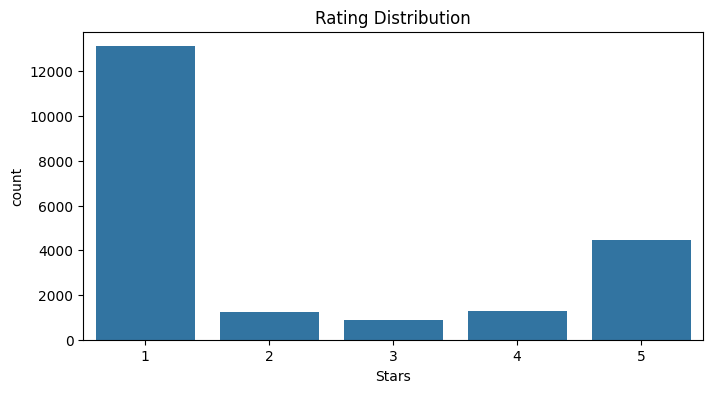

In [17]:
# Rating distribution
if 'rating_num' in df.columns:
    plt.figure(figsize=(8,4))
    order = sorted(df['rating_num'].dropna().unique())
    sns.countplot(x='rating_num', data=df, order=order)
    plt.title('Rating Distribution')
    plt.xlabel('Stars')
    plt.show()

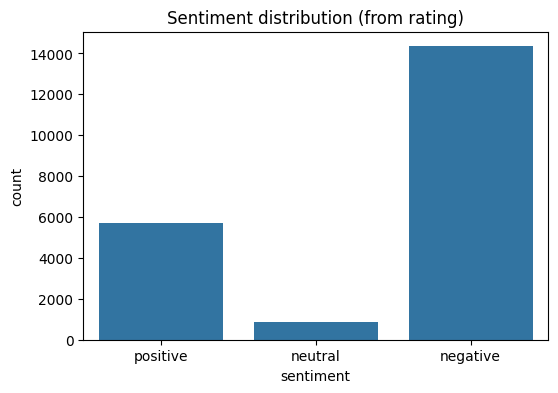

In [18]:
# Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, order=['positive','neutral','negative'])
plt.title('Sentiment distribution (from rating)')
plt.show()


/tmp/ipython-input-897471774.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_time = df.groupby(pd.Grouper(key=date_col, freq='M')).size().reset_index(name='Review Count')


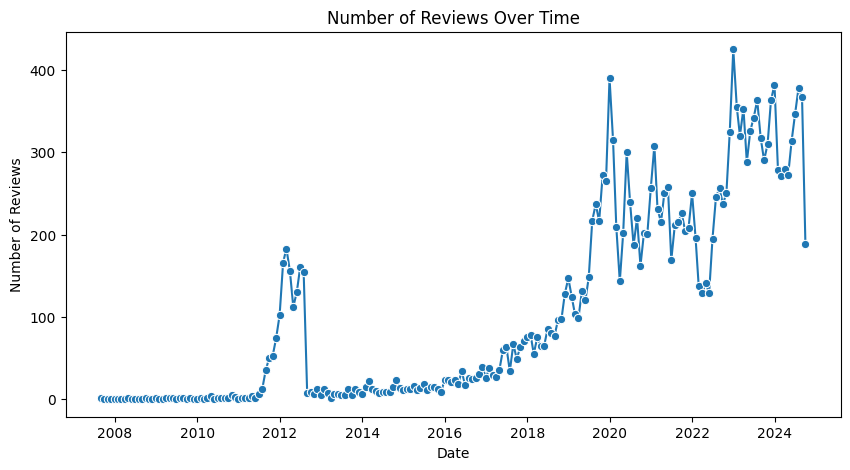

In [19]:
# Number of reviews over time
date_col = None
for c in ['Date of Experience_dt', 'Review Date_dt']:
    if c in df.columns:
        date_col = c
        break

if date_col:
    df_time = df.groupby(pd.Grouper(key=date_col, freq='M')).size().reset_index(name='Review Count')
    plt.figure(figsize=(10,5))
    sns.lineplot(x=date_col, y='Review Count', data=df_time, marker='o')
    plt.title('Number of Reviews Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Reviews')
    plt.show()



/tmp/ipython-input-3913115978.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating_num', y='Country', data=df[df['Country'].isin(top_countries)],


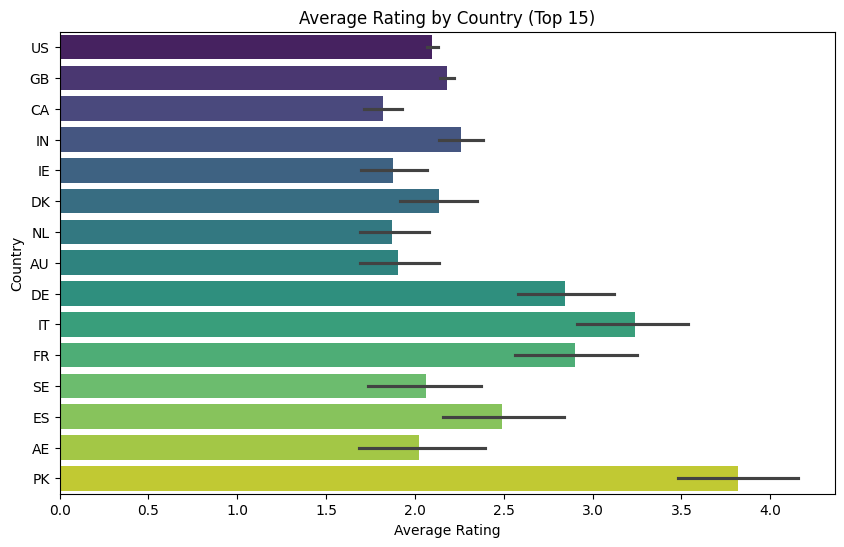

In [20]:
# Average rating by country (top 15 countries)
if 'Country' in df.columns and 'rating_num' in df.columns:
    plt.figure(figsize=(10,6))
    top_countries = df['Country'].value_counts().head(15).index
    sns.barplot(x='rating_num', y='Country', data=df[df['Country'].isin(top_countries)],
                estimator=np.mean, order=top_countries, palette='viridis')
    plt.title('Average Rating by Country (Top 15)')
    plt.xlabel('Average Rating')
    plt.ylabel('Country')
    plt.show()


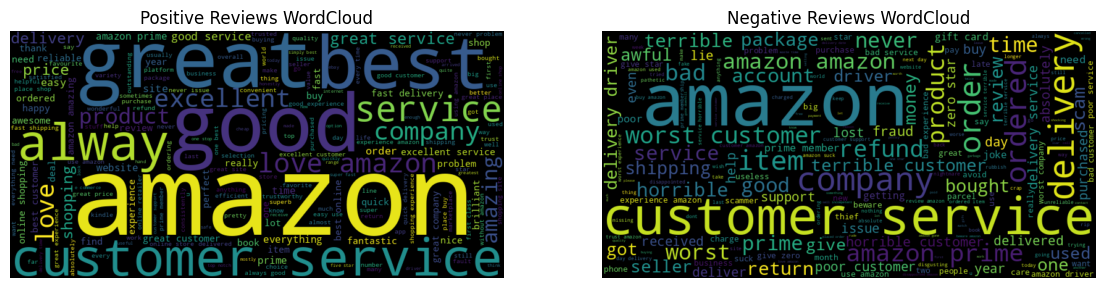

In [21]:
# -------------------------
# 7) Word Clouds
# -------------------------
try:
    from wordcloud import WordCloud
    pos_text = ' '.join(df[df['rating_num']>=4][clean_col].astype(str).tolist())
    neg_text = ' '.join(df[df['rating_num']<=2][clean_col].astype(str).tolist())

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    wc1 = WordCloud(width=800, height=400).generate(pos_text if len(pos_text)>0 else "positive")
    plt.imshow(wc1, interpolation='bilinear'); plt.axis('off'); plt.title('Positive Reviews WordCloud')

    plt.subplot(1,2,2)
    wc2 = WordCloud(width=800, height=400).generate(neg_text if len(neg_text)>0 else "negative")
    plt.imshow(wc2, interpolation='bilinear'); plt.axis('off'); plt.title('Negative Reviews WordCloud')
    plt.show()
except Exception as e:
    print("WordCloud generation failed:", e)


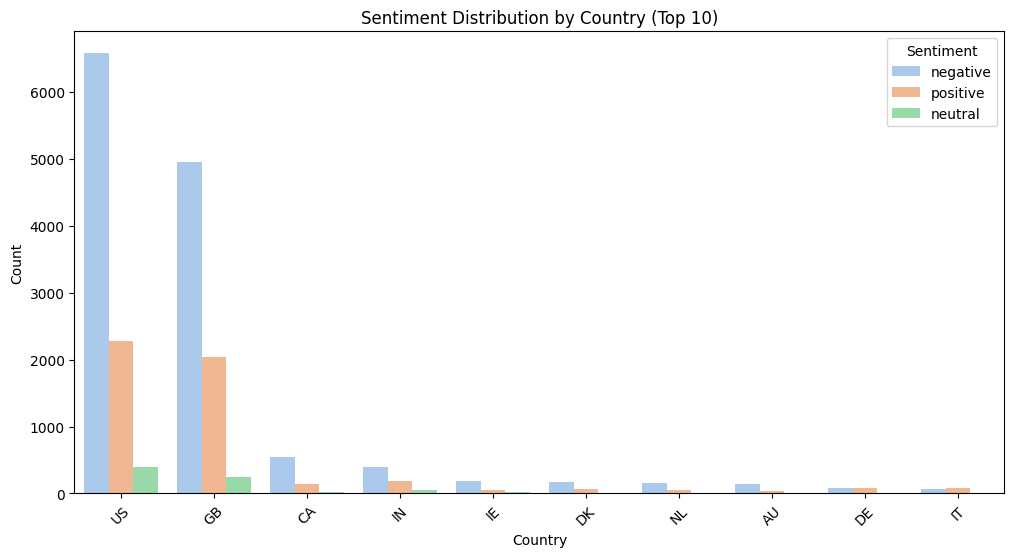

In [22]:
if 'Country' in df.columns and 'sentiment' in df.columns:
    plt.figure(figsize=(12,6))
    top_countries = df['Country'].value_counts().head(10).index
    sns.countplot(data=df[df['Country'].isin(top_countries)],
                  x='Country', hue='sentiment',
                  order=top_countries, palette='pastel')
    plt.title('Sentiment Distribution by Country (Top 10)')
    plt.xticks(rotation=45)
    plt.xlabel('Country')
    plt.ylabel('Count')
    plt.legend(title='Sentiment')
    plt.show()


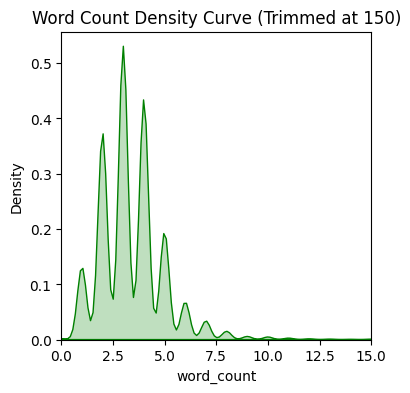

In [28]:
# Word count distribution
plt.figure(figsize=(4,4))
sns.kdeplot(df['word_count'], fill=True, bw_adjust=1, color="green")
plt.xlim(0, 15)
plt.title("Word Count Density Curve")
plt.show()


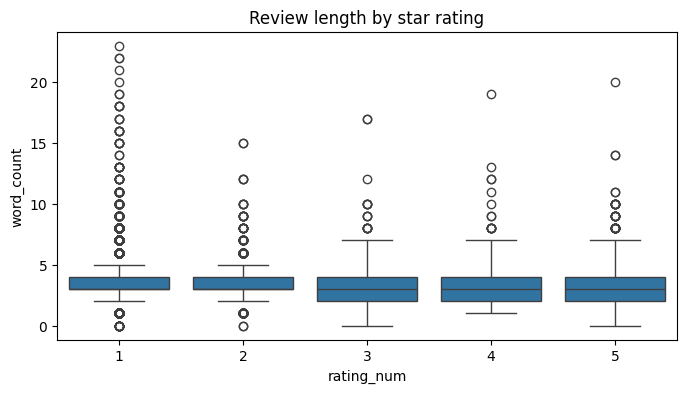

In [29]:
# Boxplot review length vs rating
if 'rating_num' in df.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='rating_num', y='word_count', data=df)
    plt.title('Review length by star rating')
    plt.show()

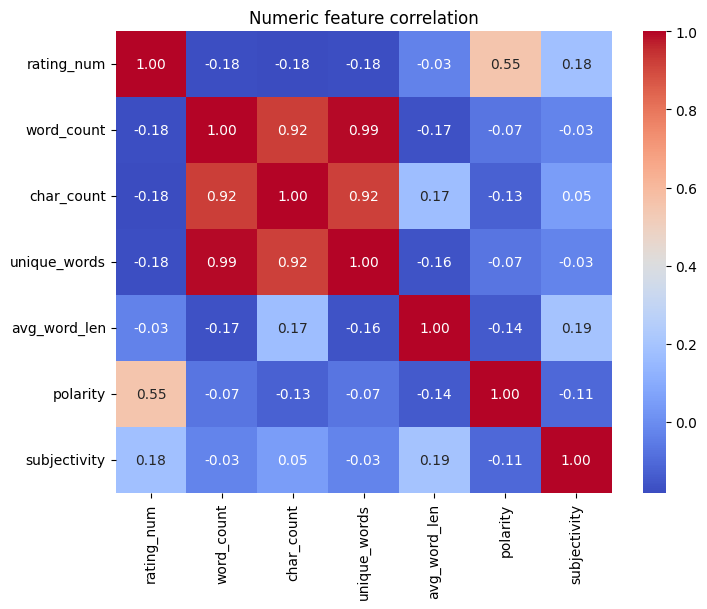

In [30]:

# Correlations
num_cols = [c for c in ['rating_num','word_count','char_count','unique_words','avg_word_len','polarity','subjectivity'] if c in df.columns]
if num_cols:
    plt.figure(figsize=(8,6))
    sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Numeric feature correlation')
    plt.show()

In [31]:
# Checking class imbalance
df['sentiment'].value_counts()

,count
sentiment,
negative,14345
positive,5718
neutral,874


In [32]:
df['sentiment'].value_counts(normalize=True) * 100


,proportion
sentiment,
negative,68.515069
positive,27.310503
neutral,4.174428


/tmp/ipython-input-3767415134.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='coolwarm')


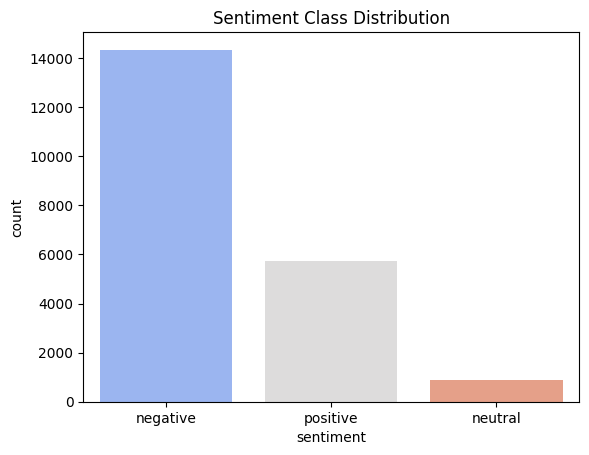

In [33]:
sns.countplot(x='sentiment', data=df, palette='coolwarm')
plt.title("Sentiment Class Distribution")
plt.show()

In [34]:
# ================================
# Logistic Regression for Sentiment Analysis
# ================================
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np

In [35]:
# --- 1. Prepare data ---
df_ml = df.dropna(subset=['Review Text_clean', 'sentiment'])
X = df_ml['Review Text_clean'].astype(str)
y = df_ml['sentiment']

print("Class distribution before balancing:")
print(y.value_counts())

Class distribution before balancing:
sentiment
negative    14345
positive     5718
neutral       874
Name: count, dtype: int64


In [36]:
# --- 2. Split into train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)


In [37]:
# --- 3. TF-IDF Vectorization ---
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    stop_words='english'
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [38]:
# --- 4. Handle Class Imbalance ---
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train_tfidf, y_train)

print("Class distribution after balancing:")
print(y_train_bal.value_counts())


Class distribution after balancing:
sentiment
negative    11476
positive    11476
neutral     11476
Name: count, dtype: int64


In [39]:
# --- 5. Logistic Regression Model ---
lr = LogisticRegression(max_iter=1000, solver='lbfgs')
lr.fit(X_train_bal, y_train_bal)

LogisticRegression(max_iter=1000)

In [40]:
# --- 6. Evaluation ---
y_pred = lr.predict(X_test_tfidf)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Weighted F1-score:", f1_score(y_test, y_pred, average='weighted'))



Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.92      0.93      2869
     neutral       0.13      0.23      0.17       175
    positive       0.85      0.80      0.83      1144

    accuracy                           0.86      4188
   macro avg       0.64      0.65      0.64      4188
weighted avg       0.88      0.86      0.87      4188

Accuracy: 0.8576886341929322
Weighted F1-score: 0.8685886105434277


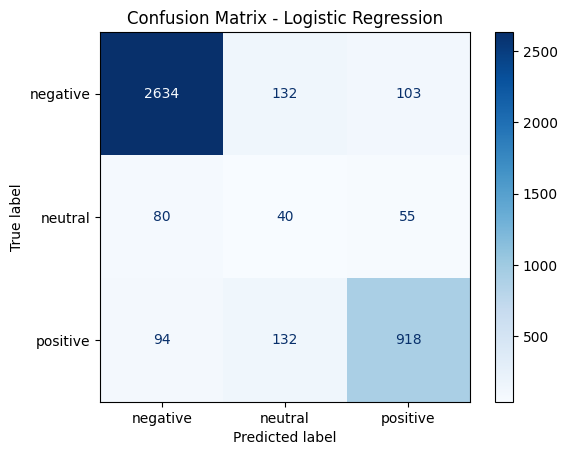

In [41]:
# --- 7. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

In [42]:
# --- 8. Feature Importance (Top Words) ---
feature_names = np.array(tfidf.get_feature_names_out())
coefficients = lr.coef_

for idx, label in enumerate(lr.classes_):
    top10 = np.argsort(coefficients[idx])[-10:]
    bottom10 = np.argsort(coefficients[idx])[:10]
    print(f"\nTop positive words for {label}: {feature_names[top10]}")
    print(f"Top negative words for {label}: {feature_names[bottom10]}")


Top positive words for negative: ['told' 'cancel' 'money' 'disgusting' 'worse' 'joke' 'poor' 'horrible'
 'account' 'worst']
Top negative words for negative: ['great' 'love' 'good' 'best' 'thank' 'amazon amazon' 'excellent' 'fast'
 'problem' 'easy']

Top positive words for neutral: ['terrible' 'feeling' 'good easy' 'end' 'letting' 'slow' 'kind' 'thank'
 'okay' 'amazon amazon']
Top negative words for neutral: ['return' 'refund' 'recommend' 'product amazon' 'quickly' 'use amazon'
 'live' 'called' 'asked' 'impressed']

Top positive words for positive: ['perfect' 'awesome' 'easy' 'excellent' 'amazing' 'fast' 'best' 'quickly'
 'love' 'great']
Top negative words for positive: ['terrible' 'account' 'money' 'letting' 'worst' 'longer' 'delayed'
 'horrible' 'lot better' 'good easy']


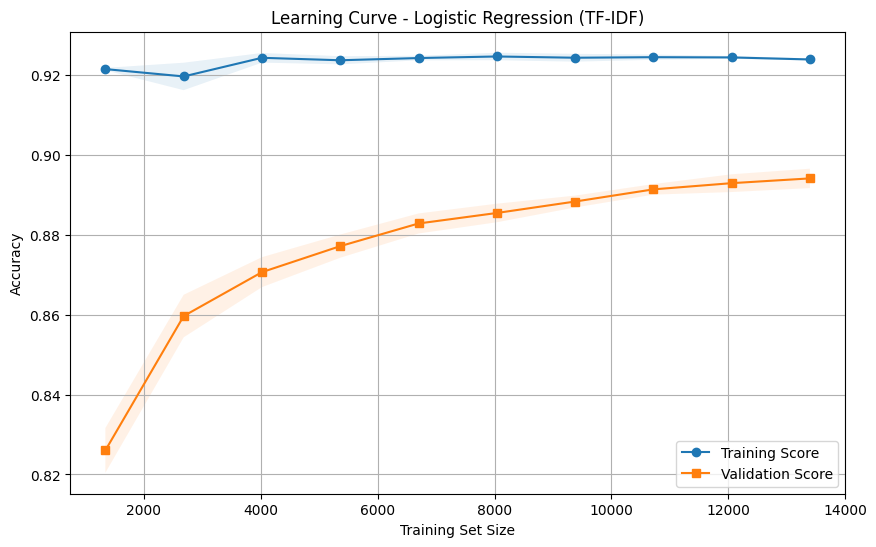

In [43]:
# ================================
# Learning Curve for Logistic Regression
# ================================
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# --- Use the same model as before ---
lr_model = LogisticRegression(max_iter=1000, solver='lbfgs')

# --- Generate learning curve ---
train_sizes, train_scores, val_scores = learning_curve(
    lr_model,
    X_train_tfidf,    # training features
    y_train,          # training labels (before balancing!)
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# --- Average scores ---
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

# --- Plot ---
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, label="Training Score", marker='o')
plt.plot(train_sizes, val_scores_mean, label="Validation Score", marker='s')

plt.fill_between(train_sizes,
                 train_scores_mean - train_scores.std(axis=1),
                 train_scores_mean + train_scores.std(axis=1),
                 alpha=0.1)

plt.fill_between(train_sizes,
                 val_scores_mean - val_scores.std(axis=1),
                 val_scores_mean + val_scores.std(axis=1),
                 alpha=0.1)

plt.title("Learning Curve - Logistic Regression (TF-IDF)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Parameters found: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

Tuned Logistic Regression Report:

              precision    recall  f1-score   support

    negative       0.93      0.93      0.93      2869
     neutral       0.12      0.18      0.14       175
    positive       0.86      0.81      0.83      1144

    accuracy                           0.86      4188
   macro avg       0.64      0.64      0.64      4188
weighted avg       0.88      0.86      0.87      4188

Confusion Matrix:
 [[2661  111   97]
 [  88   31   56]
 [  99  119  926]]
Accuracy: 0.8638968481375359


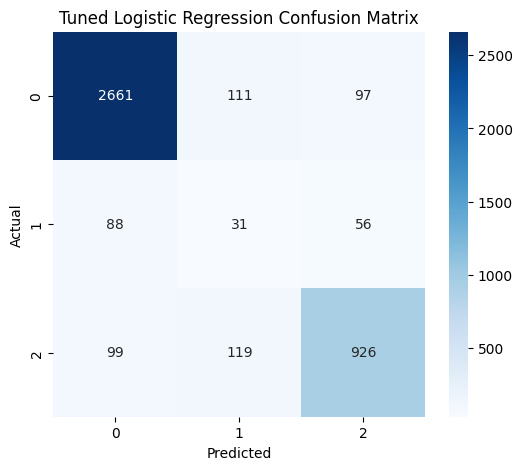

In [44]:
# ===========================================
# Logistic Regression with Hyperparameter Tuning
# ===========================================

from sklearn.model_selection import GridSearchCV

# --- 1. Define Logistic Regression and parameter grid ---
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

# --- 2. GridSearchCV setup ---
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# --- 3. Fit GridSearchCV ---
grid_search.fit(X_train_tfidf, y_train)
print("\nBest Parameters found:", grid_search.best_params_)

# --- 4. Evaluate tuned model ---
best_lr = grid_search.best_estimator_
y_pred_tuned = best_lr.predict(X_test_tfidf)

print("\nTuned Logistic Regression Report:\n")
print(classification_report(y_test, y_pred_tuned))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))

# --- 5. Visualize Confusion Matrix ---
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='d', cmap='Blues')
plt.title('Tuned Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


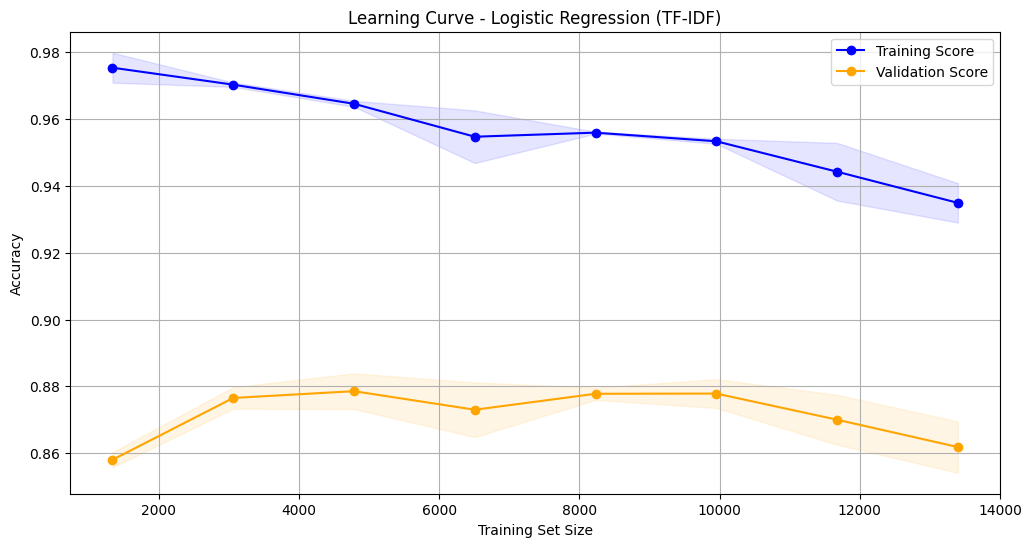

In [45]:
# ===========================================
# Learning Curve - Logistic Regression
# ===========================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression

# Use the same model definition as your training
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    estimator=lr_model,
    X=X_train_tfidf,
    y=y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)

# Compute mean + std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(12,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation Score')

# Shaded confidence intervals
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.1, color='orange')

plt.title("Learning Curve - Logistic Regression (TF-IDF)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [46]:
# ================================
# Random Forest for Sentiment Analysis (No Hyperparameter Tuning)
# ================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np


In [47]:
# --- 1. Prepare data ---
df_ml = df.dropna(subset=['Review Text_clean', 'sentiment'])
X = df_ml['Review Text_clean'].astype(str)
y = df_ml['sentiment']

print("Class distribution before balancing:")
print(y.value_counts())

Class distribution before balancing:
sentiment
negative    14345
positive     5718
neutral       874
Name: count, dtype: int64


In [49]:
# --- 2. Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [48]:
# --- 3. TF-IDF Vectorization ---
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2),
    stop_words='english'
)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [50]:

# --- 4. Handle Class Imbalance ---
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train_tfidf, y_train)

print("Class distribution after balancing:")
print(y_train_bal.value_counts())

Class distribution after balancing:
sentiment
negative    11476
positive    11476
neutral     11476
Name: count, dtype: int64


In [51]:

# --- 5. Random Forest Model ---
rf = RandomForestClassifier(
    n_estimators=200,       # number of trees
    max_depth=None,         # let trees grow fully
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_bal, y_train_bal)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [52]:
# --- 6. Evaluation ---
y_pred = rf.predict(X_test_tfidf)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Weighted F1-score:", f1_score(y_test, y_pred, average='weighted'))


Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.94      0.92      2869
     neutral       0.10      0.08      0.09       175
    positive       0.82      0.76      0.79      1144

    accuracy                           0.85      4188
   macro avg       0.61      0.59      0.60      4188
weighted avg       0.85      0.85      0.85      4188

Accuracy: 0.8538681948424068
Weighted F1-score: 0.8496306508961159


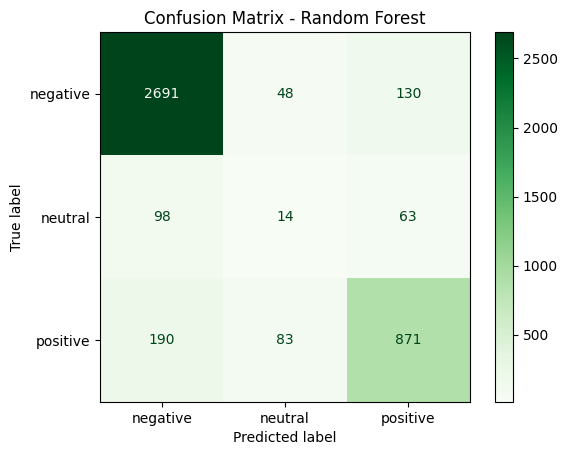

In [53]:
# --- 7. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.show()

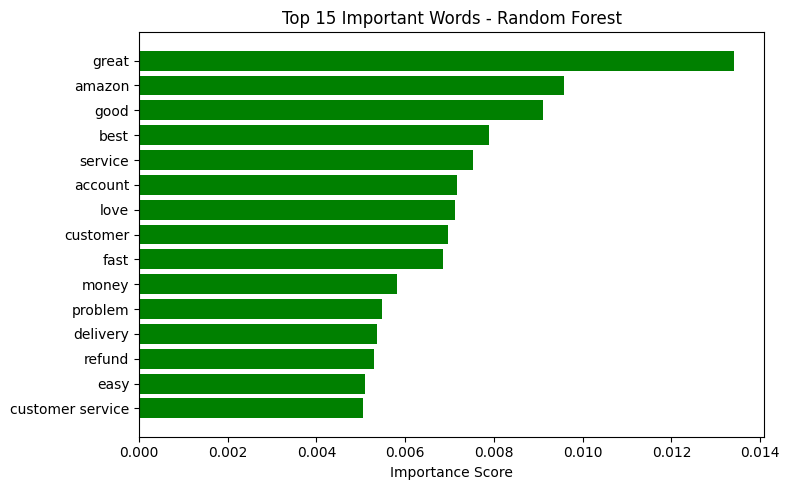

In [54]:
# --- 8. Feature Importance (Top Words) ---
feature_names = np.array(tfidf.get_feature_names_out())
importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices], color='green')
plt.yticks(range(len(indices)), feature_names[indices])
plt.title("Top 15 Important Words - Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

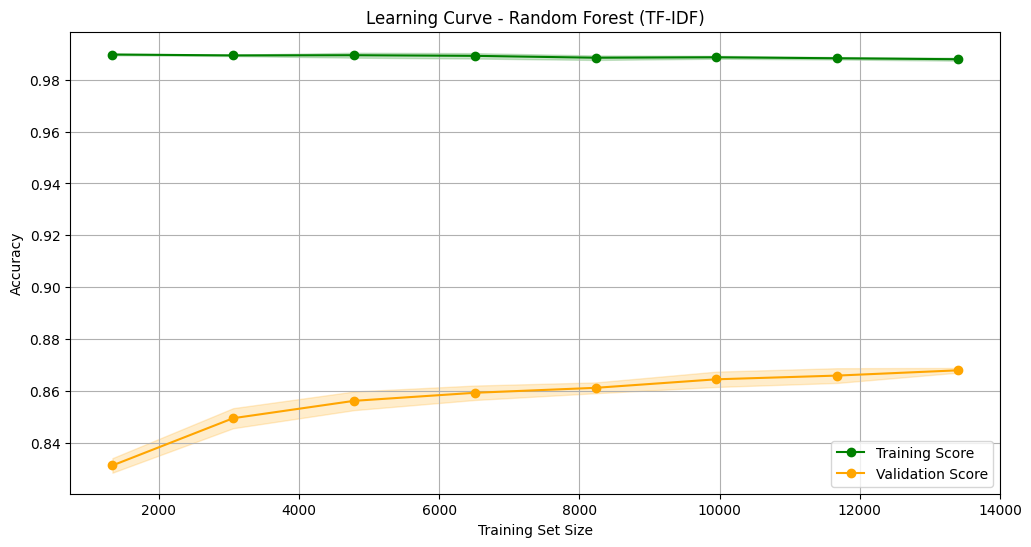

In [55]:
# ===========================================
# Learning Curve - Random Forest (TF-IDF)
# ===========================================
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# Use the SAME Random Forest model as before
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Compute learning curve
train_sizes, train_scores, val_scores = learning_curve(
    rf_model,
    X_train_tfidf,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1
)

# Compute mean & std for plotting
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, 'o-', color='green', label="Training Score")
plt.plot(train_sizes, val_mean, 'o-', color='orange', label="Validation Score")

# Shaded region for variance
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color='green')
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2, color='orange')

plt.title("Learning Curve - Random Forest (TF-IDF)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 234}

Tuned Random Forest Report (Randomized Search):

              precision    recall  f1-score   support

    negative       0.89      0.94      0.92      2869
     neutral       0.08      0.06      0.07       175
    positive       0.82      0.74      0.78      1144

    accuracy                           0.85      4188
   macro avg       0.60      0.58      0.59      4188
weighted avg       0.84      0.85      0.84      4188

Accuracy: 0.8496
F1 (Macro): 0.5862
F1 (Weighted): 0.8430


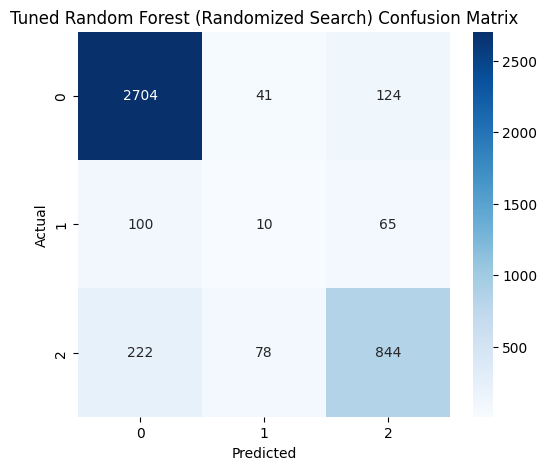

In [56]:
# ===========================================
# Random Forest with Hyperparameter Tuning (Randomized Search)
# ===========================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Define parameter distributions ---
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'max_features': ['sqrt', 'log2']
}

# --- 2. Initialize Random Forest model ---
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# --- 3. Randomized Search setup ---
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,                 # tries 20 random combinations
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# --- 4. Fit model ---
rf_random.fit(X_train_tfidf, y_train)

# --- 5. Display best parameters ---
print("\nBest Parameters found:", rf_random.best_params_)

# --- 6. Evaluate tuned model ---
best_rf = rf_random.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test_tfidf)

print("\nTuned Random Forest Report (Randomized Search):\n")
print(classification_report(y_test, y_pred_rf_tuned))

# --- Compute Accuracy and F1 Scores ---
acc = accuracy_score(y_test, y_pred_rf_tuned)
f1_macro = f1_score(y_test, y_pred_rf_tuned, average='macro')
f1_weighted = f1_score(y_test, y_pred_rf_tuned, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"F1 (Macro): {f1_macro:.4f}")
print(f"F1 (Weighted): {f1_weighted:.4f}")

# --- 7. Visualize Confusion Matrix ---
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf_tuned), annot=True, fmt='d', cmap='Blues')
plt.title('Tuned Random Forest (Randomized Search) Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


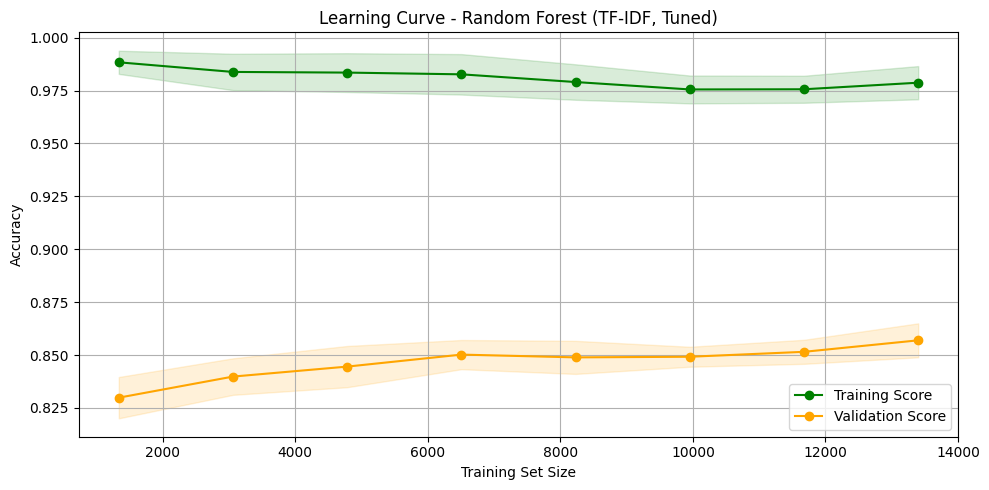

In [57]:
# ===========================================
# Learning Curve for Tuned Random Forest
# ===========================================
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# If best_rf isn't defined yet, uncomment the next line:
# best_rf = rf_random.best_estimator_

# 1. Define training set sizes (from 10% to 100% of training data)
train_sizes = np.linspace(0.1, 1.0, 8)

# 2. Compute learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_rf,
    X=X_train_tfidf,
    y=y_train,
    train_sizes=train_sizes,
    cv=5,
    scoring='accuracy',       # or 'f1_weighted'
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# 3. Take mean and std across folds
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

# 4. Plot learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Score', color='green')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Score', color='orange')

# Shaded standard deviation areas
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std,
                 alpha=0.15, color='green')
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std,
                 alpha=0.15, color='orange')

plt.title('Learning Curve - Random Forest (TF-IDF, Tuned)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# =====================================
# DistilBERT for Sentiment Analysis
# =====================================
!pip install transformers torch scikit-learn imbalanced-learn -q

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# --- 1. Prepare data ---
df_dl = df.dropna(subset=['Review Text_clean', 'sentiment']).copy()
df_dl = df_dl[df_dl['sentiment'].isin(['positive', 'negative', 'neutral'])]

# Map sentiments to integers
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {v: k for k, v in label2id.items()}
df_dl['label'] = df_dl['sentiment'].map(label2id)

# Train/test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_dl['Review Text_clean'].tolist(),
    df_dl['label'].tolist(),
    stratify=df_dl['label'],
    test_size=0.2,
    random_state=42
)

In [ ]:
# --- 2. Tokenization ---
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# --- 3. Dataset Class ---
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_encodings, train_labels)
test_dataset = ReviewDataset(test_encodings, test_labels)

In [ ]:
# --- 4. Compute class weights to handle imbalance ---
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)


In [ ]:

# --- 5. Load DistilBERT Model ---
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
pip install -U "transformers[torch]" datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 15.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.


In [ ]:
# --- 6. Training Arguments ---
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    eval_strategy="epoch",
    save_strategy="no",
    logging_dir='./logs',
    learning_rate=5e-5,
    weight_decay=0.01,
    report_to="none"
)

In [ ]:
# --- 7. Trainer Setup ---
from torch.nn import CrossEntropyLoss

# Custom loss function with class weights
# def compute_loss_with_weights(model, inputs, return_outputs=False):
#     labels = inputs.pop("labels")
#     outputs = model(**inputs)
#     logits = outputs.logits
#     loss_fct = CrossEntropyLoss(weight=class_weights.to(device))
#     loss = loss_fct(logits.view(-1, model.num_labels), labels.view(-1))
#     return (loss, outputs) if return_outputs else loss

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    # compute_loss=compute_loss_with_weights, # Removed this line
)

# --- 8. Train Model ---
from accelerate import Accelerator
accelerator = Accelerator()
trainer.accelerator = accelerator # Re-initialize accelerator

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.317700,0.318053
2,0.234300,0.320271
3,0.181500,0.364530
4,0.131400,0.457037
5,0.094900,0.536015
6,0.070700,0.572774
7,0.049000,0.637377
8,0.042900,0.653791
9,0.043200,0.682385
10,0.034900,0.695595


TrainOutput(global_step=10470, training_loss=0.12372609769717328, metrics={'train_runtime': 3798.6512, 'train_samples_per_second': 44.092, 'train_steps_per_second': 2.756, 'total_flos': 1.109368013695488e+16, 'train_loss': 0.12372609769717328, 'epoch': 10.0})

**Evaluation**

In [ ]:
# --- 9. Evaluate ---
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = test_labels

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(label2id.keys())))

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Weighted F1-score:", f1_score(y_true, y_pred, average='weighted'))


Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.94      0.94      2869
     neutral       0.23      0.18      0.20       175
    positive       0.86      0.88      0.87      1144

    accuracy                           0.89      4188
   macro avg       0.68      0.67      0.67      4188
weighted avg       0.89      0.89      0.89      4188

Accuracy: 0.894937917860554
Weighted F1-score: 0.8918556329300236


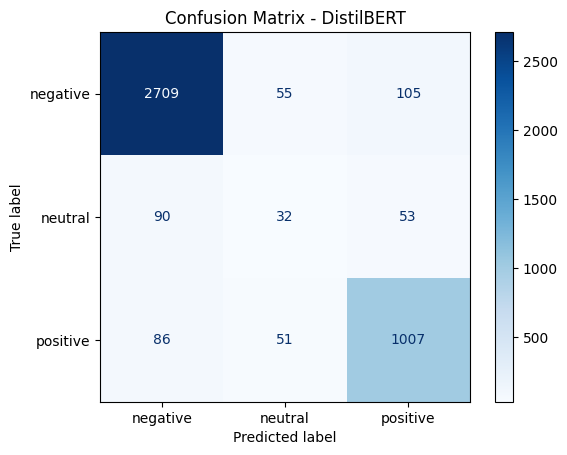

In [ ]:
# --- 10. Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - DistilBERT")
plt.show()